Pat Walters, the writer of the cheminformatics blog [Practical Cheminformatics](https://practicalcheminformatics.blogspot.com), has a [repository](https://github.com/PatWalters/datafiles) for datasets used in his blog posts. As several datasets are based on ChEMBL, there is a benefit to building reproducible workflows for re-generating them using `chembl-downloader`.

In this notebook, we'll look at a dataset of the small molecule inhibitors of [5-lipoxygenase activating protein (CHEMBL4550)](https://bioregistry.io/chembl:CHEMBL4550). It's available at as a `*.smi` file, which is a CSV file with SMILES strings in the first column and arbitarary, application-specific content in the remaining columns. In this case, the remaining two columns are a ChEMBL compound identifier and a [pChEMBL](https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/chembl-data-questions#what-is-pchembl) value. The data for this example can be found at [https://github.com/PatWalters/datafiles/raw/main/CHEMBL4550.smi](https://github.com/PatWalters/datafiles/raw/main/CHEMBL4550.smi).

In [1]:
import sys
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib_inline
import pandas as pd
import seaborn as sns
from rdkit import Chem
from scipy import stats
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

import chembl_downloader
import chembl_downloader.contrib

In [2]:
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [3]:
print(sys.version)

3.10.8 (main, Oct 13 2022, 10:17:43) [Clang 14.0.0 (clang-1400.0.29.102)]


In [4]:
print(time.asctime())

Sat Oct 29 17:49:20 2022


## Loading Walters' File

In [5]:
walters_df = pd.read_csv(
    "https://github.com/PatWalters/datafiles/raw/main/CHEMBL4550.smi",
    header=None,
    names=["canonical_smiles", "molecule_chembl_id", "pchembl_value"],
).sort_values("molecule_chembl_id")
walters_df

,canonical_smiles,molecule_chembl_id,pchembl_value
330,Nc1cnc(-c2ccc(C3CCC3)c(Oc3ncccn3)c2F)cn1,CHEMBL3586209,7.98
486,Nc1cnc(-c2ccc(C3CCC3)c(OCc3nc(C(=O)O)co3)c2F)cn1,CHEMBL3639581,7.53
1268,CCC(CC)(Cc1nc2ccc(OCc3ccn(C)n3)cc2n1Cc1ccc(OC(...,CHEMBL3639611,7.35
1315,Cn1ccc(COc2ccc3nc([C@@H]4CCCC[C@@H]4C(=O)O)n(C...,CHEMBL3639658,7.52
15,O=C(O)[C@@H]1CCCC[C@H]1c1nc2cc(OCc3ccc4ccccc4n...,CHEMBL3639771,7.92
...,...,...,...
422,CC(C)(C)c1ccc(-c2cnc(N)nc2)c(F)c1Oc1cc(N)ncn1,CHEMBL3704364,7.33
423,CC(C)(C)c1ccc(-c2cnc(N)nc2)c(F)c1Oc1nccc(N)n1,CHEMBL3704365,7.63
424,COc1c(Br)ccc(-c2cnc(N)cn2)c1F,CHEMBL3704366,5.60
425,COc1c(C2CCCC2)ccc(-c2cnc(N)cn2)c1F,CHEMBL3704367,6.28


In [6]:
walters_counts = walters_df.groupby("molecule_chembl_id").count()["pchembl_value"]
walters_duplicates = set(walters_counts[walters_counts > 1].index)

print(f"There are {len(walters_duplicates):,} duplicate compounds in the Walters data file.")

There are 0 duplicate compounds in the Walters data file.


## Rebuilding with `chembl-downloader`

In [7]:
latest_version = chembl_downloader.latest()

In [8]:
# note that if aggregate=None isn't explicitly written,
# this defaults to the arithmetic mean
df = chembl_downloader.contrib.get_target_smi_df(
    "CHEMBL4550", version=latest_version, aggregate=None
).sort_values("molecule_chembl_id")
df

,assay_chembl_id,canonical_smiles,molecule_chembl_id,pchembl_value
3,CHEMBL958743,CC(=O)Nc1ccc(O)cc1,CHEMBL112,4.36
186,CHEMBL1211525,COc1cnc(-c2ccc(Cn3c(CC(C)(C)C(=O)[O-])c(SC(C)(...,CHEMBL1210423,8.70
190,CHEMBL1924524,COc1cnc(-c2ccc(Cn3c(CC(C)(C)C(=O)O)c(SC(C)(C)C...,CHEMBL1229205,9.22
189,CHEMBL1924522,COc1cnc(-c2ccc(Cn3c(CC(C)(C)C(=O)O)c(SC(C)(C)C...,CHEMBL1229205,7.09
188,CHEMBL1924521,COc1cnc(-c2ccc(Cn3c(CC(C)(C)C(=O)O)c(SC(C)(C)C...,CHEMBL1229205,6.79
...,...,...,...,...
2,CHEMBL3783530,CC(c1cc2ccccc2s1)N(O)C(N)=O,CHEMBL93,6.24
1,CHEMBL1924522,CC(c1cc2ccccc2s1)N(O)C(N)=O,CHEMBL93,5.38
0,CHEMBL1924521,CC(c1cc2ccccc2s1)N(O)C(N)=O,CHEMBL93,5.66
80,CHEMBL618418,CC1Cc2c(OCc3ccccn3)ccc3c2c(c(CC(C)(C)C(=O)O)n3...,CHEMBL96412,6.96


In [9]:
counts = df.groupby("molecule_chembl_id").count()["pchembl_value"]
duplicates = set(counts[counts > 1].index)

print(f"There are {len(duplicates):,} duplicate compounds in the new data file.")

There are 341 duplicate compounds in the new data file.


## Choosing an Appropriate Aggregation

Because this dataset covers several assays, there are multiple values for each. The following cell shows the intersecting chemicals between the Walters dataset and the new dataset (where duplicates exist). It compares the arithmetic mean (i.e., the average) as well as the geometric mean to see which one is correct to regenerate the file.

In [10]:
comparison_df = walters_df[walters_df["molecule_chembl_id"].isin(duplicates)].copy()

comparison_idx = df["molecule_chembl_id"].isin(set(walters_df["molecule_chembl_id"])) & df[
    "molecule_chembl_id"
].isin(duplicates)
comparison_df["new_mean"] = (
    df[comparison_idx].groupby("molecule_chembl_id").mean(numeric_only=True).values
)
comparison_df["new_gmean"] = (
    df[comparison_idx].groupby("molecule_chembl_id").agg(stats.gmean).values.round(3)
)

comparison_df

/var/folders/f8/snw3tlcs0y3bmnq5gqg26b5h0000gn/T/ipykernel_78894/3931957630.py:8: FutureWarning: ['assay_chembl_id', 'canonical_smiles'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  comparison_df["new_gmean"] = df[comparison_idx].groupby("molecule_chembl_id").agg(stats.gmean).values.round(3)


,canonical_smiles,molecule_chembl_id,pchembl_value,new_mean,new_gmean
1268,CCC(CC)(Cc1nc2ccc(OCc3ccn(C)n3)cc2n1Cc1ccc(OC(...,CHEMBL3639611,7.350,7.350,7.350
475,COC(=O)c1ccc2oc(COc3c(C4CCC4)ccc(-c4cnc(N)cn4)...,CHEMBL3659294,7.710,7.710,7.710
476,COC(=O)c1ccc(O)c(NC(=O)COc2c(C3CCC3)ccc(-c3cnc...,CHEMBL3659295,6.860,6.860,6.860
1233,CCC(CC)(Cc1nc2ccc(OCc3ccc(C)cn3)cc2n1Cc1ccc(Br...,CHEMBL3662241,8.000,8.000,8.000
1234,Cc1ccc(COc2ccc3nc(CC4(C(=O)O)CCCC4)n(Cc4ccc(Br...,CHEMBL3662242,7.740,7.750,7.750
...,...,...,...,...,...
605,Nc1cnc(-c2ccc(-c3ccccc3S(=O)(=O)N3CC[C@H](N)C3...,CHEMBL3688481,6.695,6.695,6.692
722,Nc1cnc(-c2ccc(-c3ccccc3CSc3nccc(N)n3)cc2F)cn1,CHEMBL3688593,8.230,8.230,8.229
739,Nc1ncc(-c2ccc(-c3ccccc3S(=O)(=O)C3CC3)cc2F)cn1,CHEMBL3693003,7.100,7.020,7.020
762,C[C@H](O)CNS(=O)(=O)c1ccccc1-c1ccc(-c2cnc(N)nc...,CHEMBL3693026,7.295,7.300,7.299


Even though they're pretty close, it appears the arithmetic mean was used.

In [11]:
agg_df = (
    df.groupby(["canonical_smiles", "molecule_chembl_id"])
    .mean(numeric_only=True)["pchembl_value"]
    .reset_index()
)
agg_df

,canonical_smiles,molecule_chembl_id,pchembl_value
0,Br.O=C(Nc1cccnc1)Oc1ccc(OCc2nc3ccccc3s2)cc1C1(...,CHEMBL541915,8.620
1,C.Nc1cnc(-c2ccc(-c3ccccc3S(=O)(=O)N3C[C@H]4C[C...,CHEMBL4110733,6.890
2,C1=CC(COc2ccc(OCc3ccc4ccccc4n3)cc2C2(c3ccccc3)...,CHEMBL255227,8.600
3,C=C(Cc1ccc(-c2cnc(N)nc2)cc1)c1nc2cc(C#N)ccc2n1...,CHEMBL4250880,6.430
4,C=CCOc1ccc2c(c1)nc(C(C)c1ccc(CC(C)C)cc1)n2Cc1c...,CHEMBL3927809,6.770
...,...,...,...
2153,c1ccc(COc2ccc(OCc3ccc4ccccc4n3)cc2C2(c3ccccc3)...,CHEMBL430038,8.070
2154,c1ccc([C@@]2(c3cc(OCc4ccc5ccccc5n4)ccc3-c3ncon...,CHEMBL2031650,7.205
2155,c1ccc([C@@]2(c3cc(OCc4ccc5ccccc5n4)ccc3-c3nn[n...,CHEMBL2031652,6.890
2156,c1ccc([C@@]2(c3cc(OCc4ccc5ccccc5n4)ccc3-c3nnco...,CHEMBL2031649,7.480


## Summary of Value Added

The following plots a histogram of pChEMBL values of the two datasets The newer version of ChEMBL provides a greater variety of pChEMBL scores as well as a total larger number of compounds.

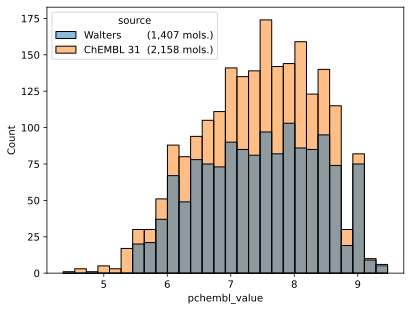

In [12]:
walters_df["source"] = f"Walters        ({len(walters_df.index):,} mols.)"
agg_df["source"] = f"ChEMBL {latest_version}  ({len(agg_df.index):,} mols.)"
concat_df = pd.concat([walters_df, agg_df])

sns.histplot(data=concat_df, x="pchembl_value", hue="source")
plt.show()

## Chemical Space Added

Combining topological fingerprints and a dimensionality reduction technique, it can be seen that there's added chemical space covered by newer data (likely from new assays).

In [13]:
fps = [Chem.RDKFingerprint(Chem.MolFromSmiles(smiles)) for smiles in agg_df.canonical_smiles]
wp_fps = [Chem.RDKFingerprint(Chem.MolFromSmiles(smiles)) for smiles in walters_df.canonical_smiles]

In [14]:
pca = PCA(2)
reduced_fps = pca.fit_transform(fps)
wp_reduced_fps = pca.transform(wp_fps)

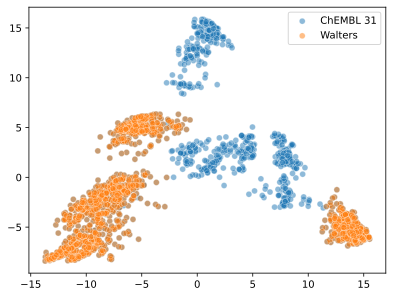

In [15]:
fig, ax = plt.subplots()

sns.scatterplot(
    x=reduced_fps[:, 0],
    y=reduced_fps[:, 1],
    ax=ax,
    label=f"ChEMBL {latest_version}",
    alpha=0.5,
)
sns.scatterplot(
    x=wp_reduced_fps[:, 0],
    y=wp_reduced_fps[:, 1],
    ax=ax,
    label="Walters",
    alpha=0.5,
)
plt.show()